# Diffusion Models

In [1]:
from google.colab import drive
drive.mount('/content/drive') ## mount drive

import os
path = "/content/drive/MyDrive/code/genaibook/"
os.chdir(path)
print(os.getcwd())

%ls
!pip show tensorflow
!pip install -U datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/code/genaibook
01_introduction.ipynb                 07_fine_tuning_diffusion.ipynb
02_transformers.ipynb                 08_creative_applications_of_t2i.ipynb
03_compressing.ipynb                  09_generating_audio.ipynb
04_diffusion.ipynb                    13_rag.ipynb
05_stable_diffusion.ipynb             pyproject.toml
06_fine_tuning_language_models.ipynb  README.md
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorf

This notebook is a supplementary material for the Introduction Chapter of the [Hands-On Generative AI with Transformers and Diffusion Models book](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/). This notebook includes:

* The code from the book
* Additional examples
* Exercise solutions

## The Key Insight: Iterative Refinement

In [2]:
import datasets
import diffusers
import huggingface_hub

datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

In [3]:
!pip install genaibook

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.


  0%|          | 0/1000 [00:00<?, ?it/s]

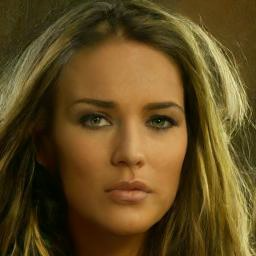

In [4]:
import torch
from diffusers import DDPMPipeline

from genaibook.core import get_device

# We can set the device to use our GPU or CPU
device = get_device()

# Load the pipeline
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

# Sample an image
image_pipe().images[0]

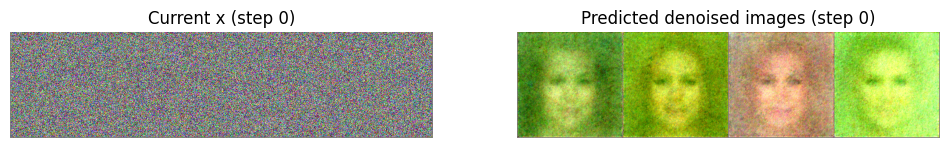

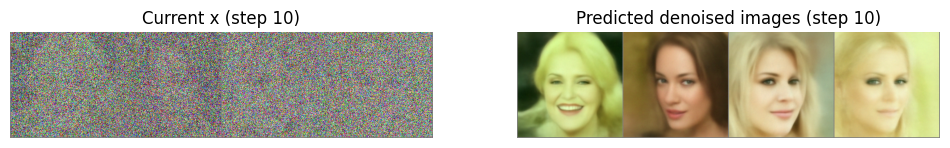

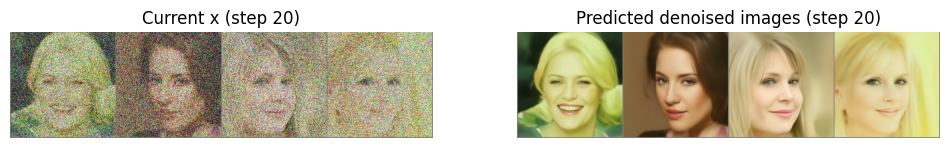

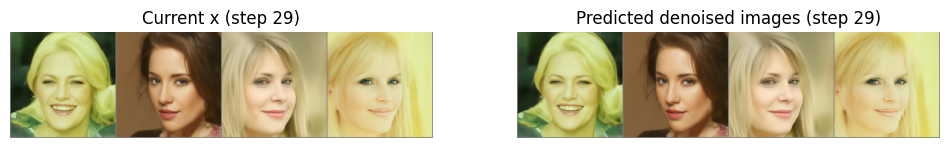

In [5]:
from genaibook.core import plot_noise_and_denoise

# The random starting point is a batch of 4 images
# Each image is 3-channel (RGB) 256x256 pixel image
image = torch.randn(4, 3, 256, 256).to(device)

# Set the specific number of diffusion steps
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipe.scheduler.timesteps):
    # Get the prediction given the current sample x and the timestep t
    # As we're running inference, we don't need to calculate gradients,
    # so we can use torch.inference_mode().
    with torch.inference_mode():
        # We need to pass in the timestep t so that the model knows what
        # timestep it's currently at. We'll learn more about this in the
        # coming sections.
        noise_pred = image_pipe.unet(image, t)["sample"]

    # Calculate what the updated x should look like with the scheduler
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)

    # Update x
    image = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        plot_noise_and_denoise(scheduler_output, i)

## Training a Diffusion Model

### The Data

In [6]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
from torchvision import transforms

# We keep this higher than in the book in this part for visualization
image_size = 384

# Define transformations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [8]:
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

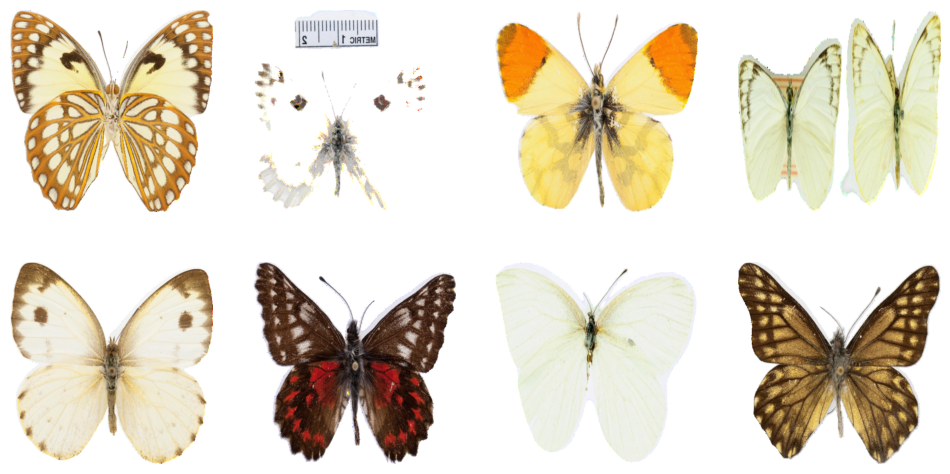

In [9]:
from genaibook.core import show_images

batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images(batch["images"][:8] * 0.5 + 0.5)

### Adding Noise


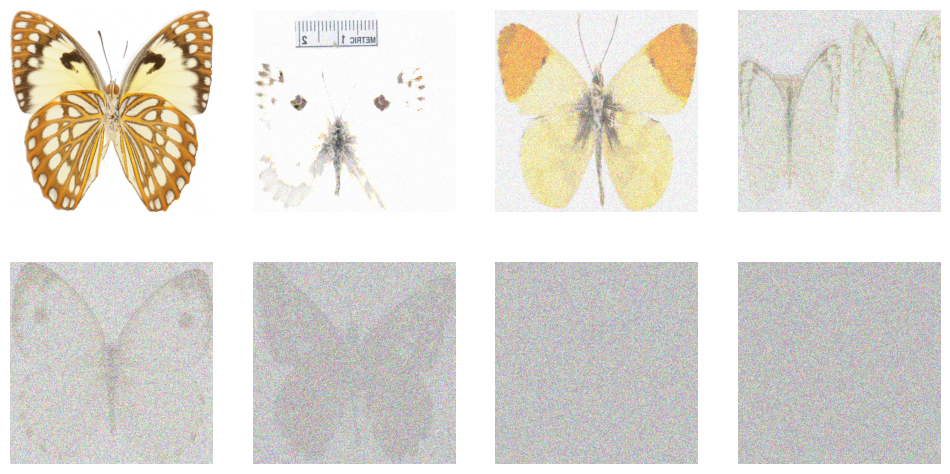

In [10]:
from diffusers import DDPMScheduler

# We'll learn about beta_start and beta_end in the next sections
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

# Create a tensor with 8 evenly spaced values
# from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

### The UNet

In [11]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Pass a batch of data through to make sure it works
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 3, 384, 384])
torch.Size([8, 3, 384, 384])


### Training

In [12]:
from torchvision import transforms

batch_size = 32

def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

# We reset to the initial size (64)
dataset.set_transform(transform)
image_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [13]:
from torch.nn import functional as F

num_epochs = 50  # How many runs through the data should we do?
lr = 1e-4  # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model (this takes a while)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # The model also uses the timestep as an input
        # for additional conditioning
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # Print out the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.444805
Finished epoch 1. Average loss for this epoch: 0.115632
Finished epoch 2. Average loss for this epoch: 0.079888
Finished epoch 3. Average loss for this epoch: 0.074142
Finished epoch 4. Average loss for this epoch: 0.061055
Finished epoch 5. Average loss for this epoch: 0.052420
Finished epoch 6. Average loss for this epoch: 0.054194
Finished epoch 7. Average loss for this epoch: 0.043764
Finished epoch 8. Average loss for this epoch: 0.041153
Finished epoch 9. Average loss for this epoch: 0.037547
Finished epoch 10. Average loss for this epoch: 0.034548
Finished epoch 11. Average loss for this epoch: 0.031198
Finished epoch 12. Average loss for this epoch: 0.032879
Finished epoch 13. Average loss for this epoch: 0.029102
Finished epoch 14. Average loss for this epoch: 0.026972
Finished epoch 15. Average loss for this epoch: 0.028990
Finished epoch 16. Average loss for this epoch: 0.027093
Finished epoch 17. Average loss for this 

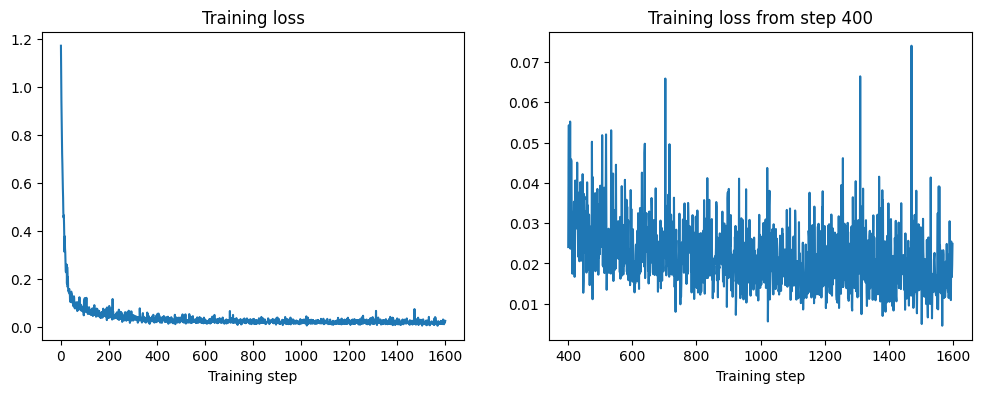

In [14]:
from matplotlib import pyplot as plt

plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

### Sampling

  0%|          | 0/1000 [00:00<?, ?it/s]

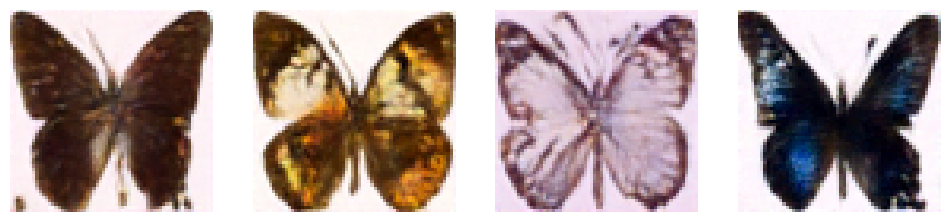

In [15]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1)

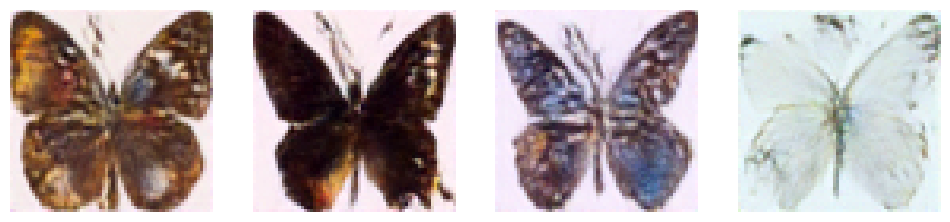

In [16]:
# Random starting point (4 random images):
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    # Get the model prediction
    with torch.inference_mode():
        noise_pred = model(sample, t)["sample"]

    # Update sample with step
    sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)

## In Depth: Noise Schedules

### Starting Simple


In [17]:
x = next(iter(train_dataloader))["images"][:8]
noise = torch.rand_like(x)

In [18]:
def corrupt(x, noise, amount):
    # Reshape amount so it works correctly with the original data
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable

    # Blend the original data and noise based on the amount
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

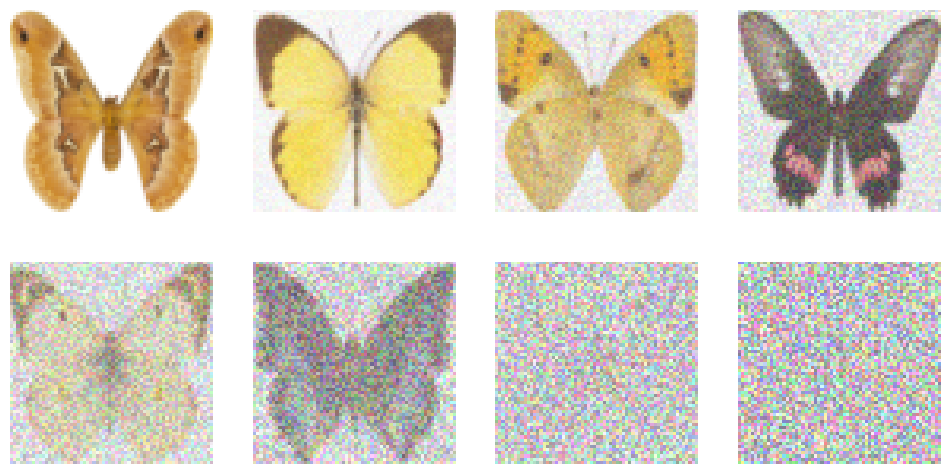

In [19]:
amount = torch.linspace(0, 1, 8)
noised_x = corrupt(x, noise, amount)
show_images(noised_x * 0.5 + 0.5)

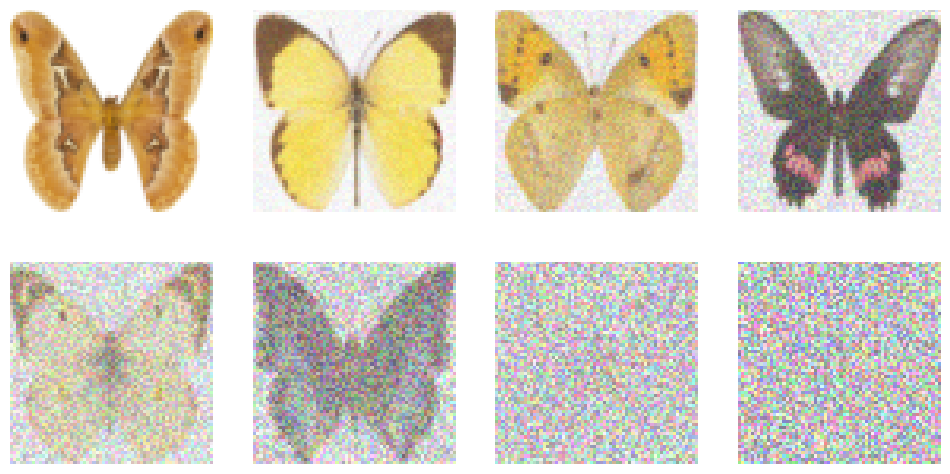

In [20]:
class SimpleScheduler:
    def __init__(self):
        self.num_train_timesteps = 1000

    def add_noise(self, x, noise, timesteps):
        amount = timesteps / self.num_train_timesteps
        return corrupt(x, noise, amount)


scheduler = SimpleScheduler()
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images(noised_x * 0.5 + 0.5)

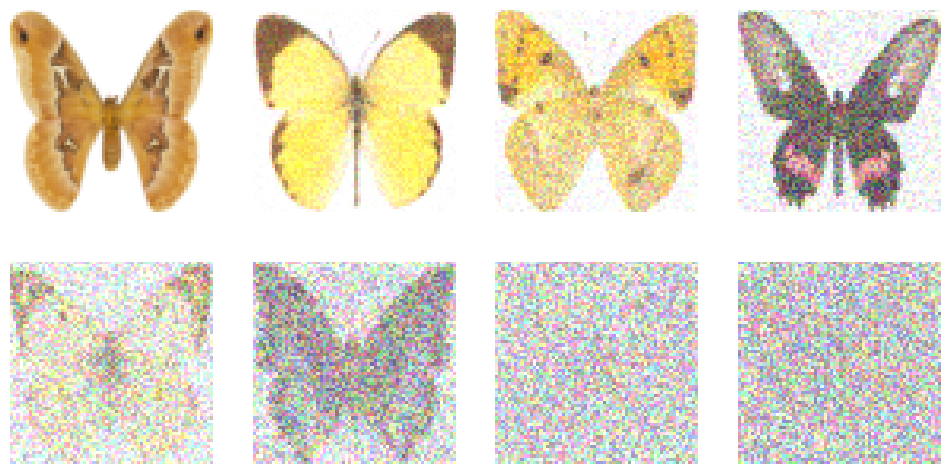

In [21]:
scheduler = DDPMScheduler(beta_end=0.01)
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

### The Math

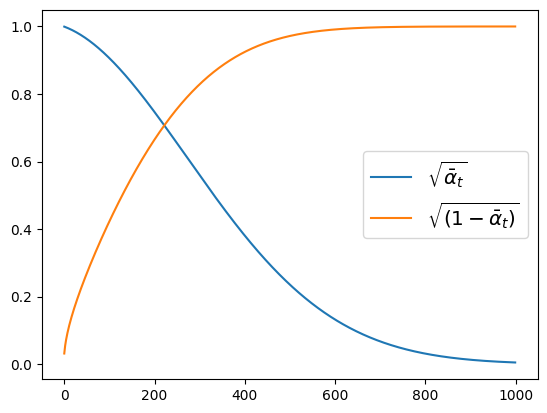

In [22]:
from genaibook.core import plot_scheduler

plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.02, beta_schedule="linear")
)

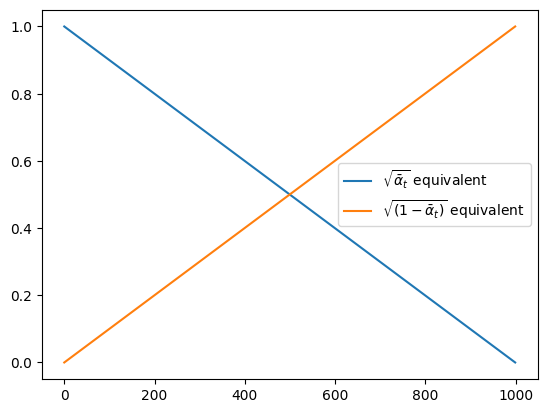

In [23]:
plot_scheduler(SimpleScheduler())

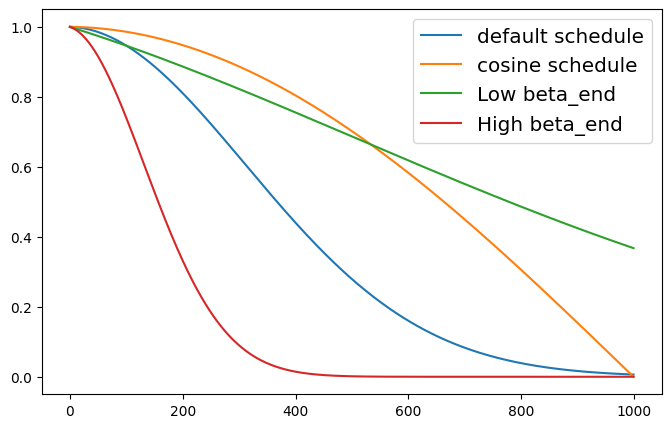

In [24]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 5))
plot_scheduler(
    DDPMScheduler(beta_schedule="linear"),
    label="default schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_schedule="squaredcos_cap_v2"),
    label="cosine schedule",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.003, beta_schedule="linear"),
    label="Low beta_end",
    ax=ax,
    plot_both=False,
)
plot_scheduler(
    DDPMScheduler(beta_start=0.001, beta_end=0.1, beta_schedule="linear"),
    label="High beta_end",
    ax=ax,
    plot_both=False,
)

### Effect of Input Resolution and Scaling

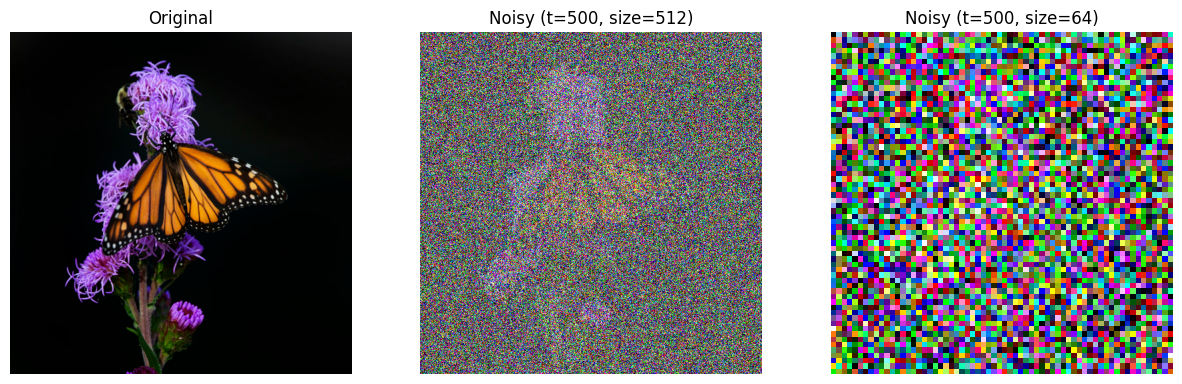

In [25]:
from genaibook.core import load_image

scheduler = DDPMScheduler(beta_end=0.05, beta_schedule="scaled_linear")
image = load_image(
    "https://images.pexels.com/photos/15403949/pexels-photo-15403949.jpeg",
    size=((512, 512)),
    return_tensor=True,
)
small_image = transforms.functional.resize(image, 64, antialias=True)
t = torch.tensor(500)  # The timestep we're noising to
show_images(
    [
        image,
        scheduler.add_noise(image * 2 - 1, torch.randn_like(image), t).clip(
            -1, 1
        )
        * 0.5
        + 0.5,
        scheduler.add_noise(
            small_image * 2 - 1, torch.randn_like(small_image), t
        ).clip(-1, 1)
        * 0.5
        + 0.5,
    ],
    titles=["Original", "Noisy (t=500, size=512)", "Noisy (t=500, size=64)"],
    figsize=(15, 5),
)

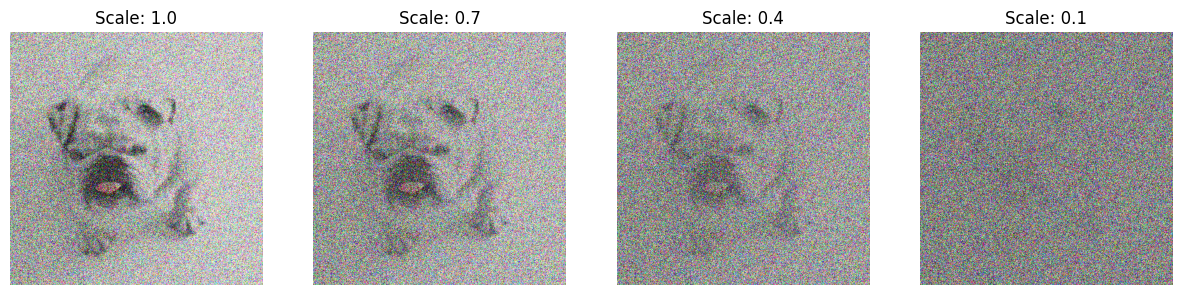

In [26]:
import numpy as np
from genaibook.core import SampleURL

scheduler = DDPMScheduler(beta_end=0.05, beta_schedule="scaled_linear")
image = load_image(
    SampleURL.DogExample,
    size=((512, 512)),
    return_tensor=True,
)

t = torch.tensor(300)  # The timestep we're noising to
scales = np.linspace(0.1, 1.0, 4)

images = [image]
noise = torch.randn_like(image)
for b in reversed(scales):
    noised = (
        scheduler.add_noise(b * (image * 2 - 1), noise, t).clip(-1, 1) * 0.5
        + 0.5
    )
    images.append(noised)

show_images(
    images[1:],
    nrows=1,
    titles=[f"Scale: {b}" for b in reversed(scales)],
    figsize=(15, 5),
)

## In Depth: UNets and Alternatives

### A Simple UNet

In [27]:
from torch import nn


class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        # Use the SiLU activation function, which has been shown to work well
        # due to different properties (smoothness, non-monotonicity, etc.).
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))

        return x

In this additional section, we'll train an unconditional diffusion model. We'll use a toy dataset called [MNIST](https://huggingface.co/datasets/mnist), which contains 70,000 28x28 black and white images of handwritten digits. We'll train a diffusion model to generate images of digits resembling this dataset. We'll train with our custom `UNet` first as explained in the `A Simple UNet` section.

### Exploring the data

We begin by loading the data with the `datasets` library.

In [28]:
from datasets import load_dataset

dataset = load_dataset("mnist")

README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

We make sure the images are the expected size, just as in the chapter. We also visualize a few images to get a sense of the data. Note we do not do random flips (it would not make much sense for digits!) and we use values between 0 and 1 for the pixel values.

In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

image_size = 32
batch_size = 8


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

Input shape: torch.Size([8, 1, 32, 32])


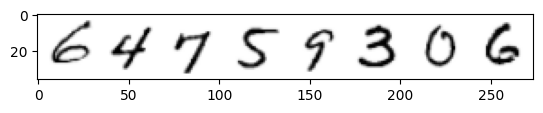

In [30]:
import torchvision
from matplotlib import pyplot as plt

imgs = next(iter(train_dataloader))["images"]
print("Input shape:", imgs.shape)
plt.imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys");

### Corruption

Let's implement a function that will add some amount of configurable noise to the input images. This is the same as in the chapter.

In [31]:
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

Let's visualize the effect of applying noise to the images.

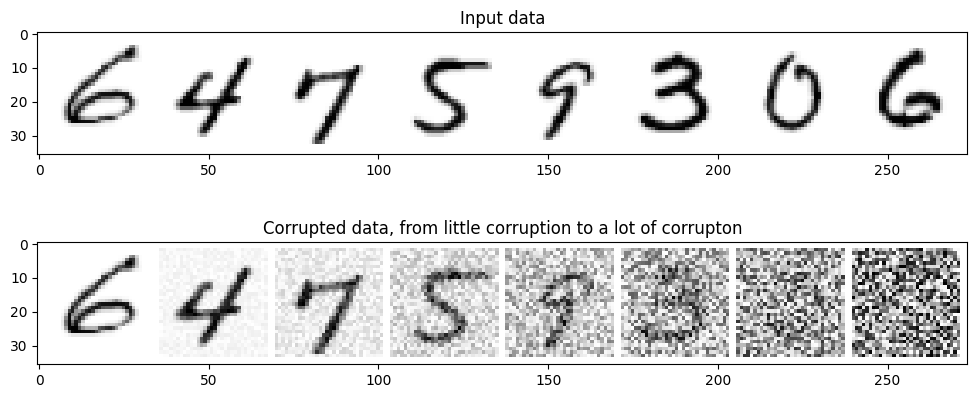

In [32]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")

# Adding noise (we go from little corruption to a lot)
amount = torch.linspace(0, 1, imgs.shape[0])
noise = torch.rand_like(imgs)
noised_x = corrupt(imgs, noise, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data, from little corruption to a lot of corrupton")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

### Basic UNet

We begin by using a minimal UNet as described in the book (implementation at the top of this section). Some details about this UNet

* Works with single-chanel images, such as grayscale images.
* Has a downscaling and an upscaling path, each with three layers
* Each layer consists on a convolution and an activation (`nn.SiLU`) followed by a downscaling or upscaling step. Note that neither the last layer of the downscaling nor the first layer of the upscaling perform the down or upscaling.
* There are skip connections between downsampling and upsampling blocks.

Let's verify that the output shape is the same as the input:

In [33]:
net = BasicUNet()
x = torch.rand(8, 1, 32, 32)
net(x).shape

torch.Size([8, 1, 32, 32])

### Training model

Let's recall the process. For each training step, we:

1. Load a batch of images,
2. Add noise to the images,
3. Feed the noisy images into the model,
4. Calculate the loss.
5. Backpropagate and update weights with the optimizer.

In [34]:
from torch.nn import functional as F

device = get_device()
num_epochs = 5  # How many runs through the data should we do?
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

model = BasicUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        # In the chapter, we use the noise scheduler to manage this
        # as we can pass the timestep. Here, we keep it simple and
        # just sample a random amount of noise to add to the images.
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # Get the model prediction
        pred = model(noisy_x)

        # Compare the prediction with the actual image
        # Big note: in the book, we optimize the model to reduce difference
        # the generation and the noise, so the model learns to predict the noise.
        # Here, we calculate the loss between the image and the generation, so the
        # model learns to generate the images directly.
        loss = F.mse_loss(pred, clean_images)

        # Update the model parameters with the optimizer based on this loss
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later plotting
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.019220
Finished epoch 1. Average loss for this epoch: 0.011252
Finished epoch 2. Average loss for this epoch: 0.010234
Finished epoch 3. Average loss for this epoch: 0.009719
Finished epoch 4. Average loss for this epoch: 0.009368


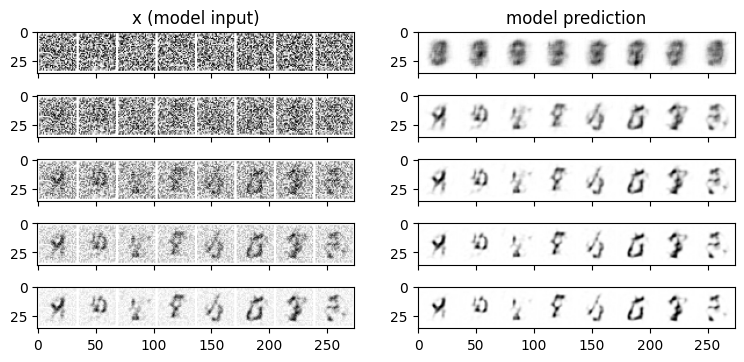

In [35]:
n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    # Predict denoise image
    with torch.no_grad():
        pred = model(x)

    # Store output for plotting
    pred_output_history.append(pred.detach().cpu())

    # Move slightly towards that direction
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

    # Store output for plotting
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1),
        cmap="Greys",
    )

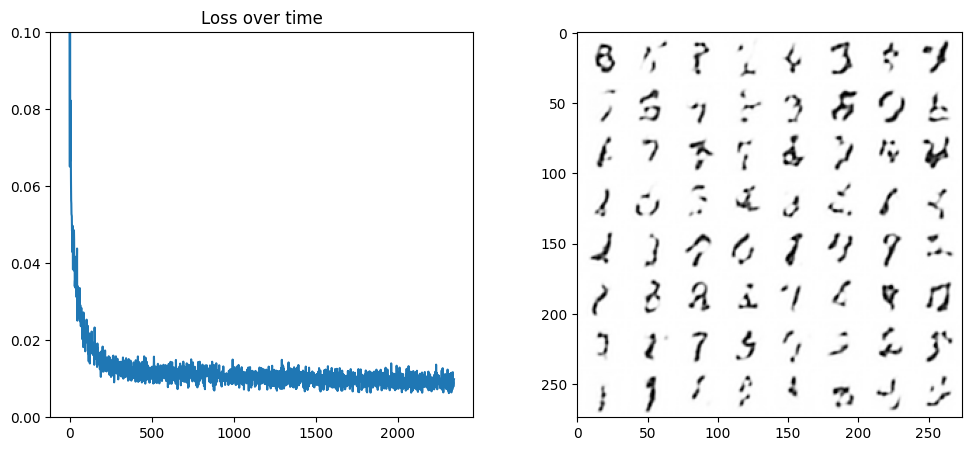

In [36]:
import torchvision
from matplotlib import pyplot as plt

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 32, 32).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)

In [37]:
basic_losses = losses
basic_model = model

OK...the generations are not great. Can we do better?

### Diffusers UNet

Let's now use the `diffusers` library UNet implementation. This integrates a couple of additions:

* More parameters (e.g. by having two convolutional layers per block)
* Batch normalization, which helps learn more quickly and reliably.
* Self-attention layers that allow to focus on different pars of the images at different times.

In [38]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [39]:
sum(
    [p.numel() for p in model.parameters()]
)  # 1.7M vs the ~309k parameters of the BasicUNet

1707009

As this model is larger, the training will take a bit longer.

In [40]:
batch_size = 128
train_dataloader = DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)
num_epochs = 5

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # Get the model prediction using timestep 0
        pred = model(noisy_x, 0).sample

        # Compare the prediction with the actual image
        # Big note: in the book, we optimize the model to reduce difference
        # the generation and the noise, so the model learns to predict the noise.
        # Here, we calculate the loss between the image and the generation, so the
        # model learns to generate the images directly.
        loss = F.mse_loss(pred, clean_images)

        # Update the model parameters with the optimizer based on this loss
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later plotting
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.012113
Finished epoch 1. Average loss for this epoch: 0.007170
Finished epoch 2. Average loss for this epoch: 0.006298
Finished epoch 3. Average loss for this epoch: 0.005751
Finished epoch 4. Average loss for this epoch: 0.005419


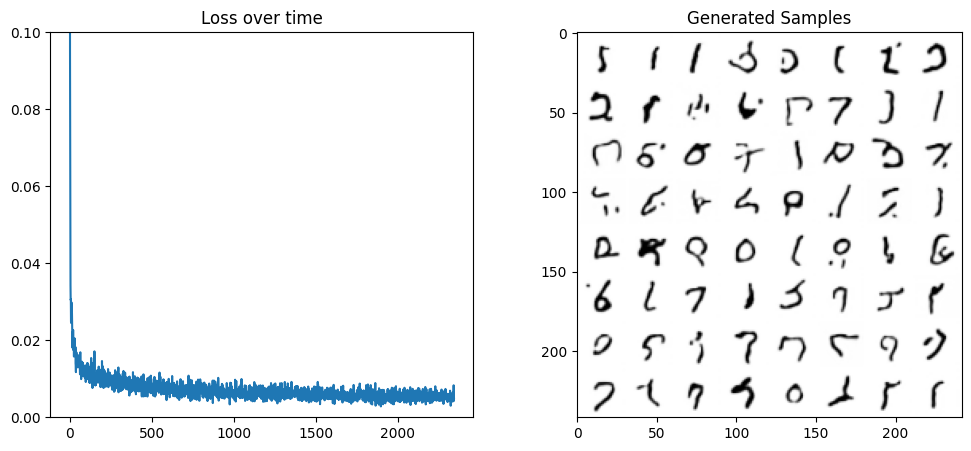

In [41]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)
axs[1].set_title("Generated Samples");

Much better! Still, not perfect, but a great improvement for a model we can quickly train.

Plot losses together with the ones from the previous model.

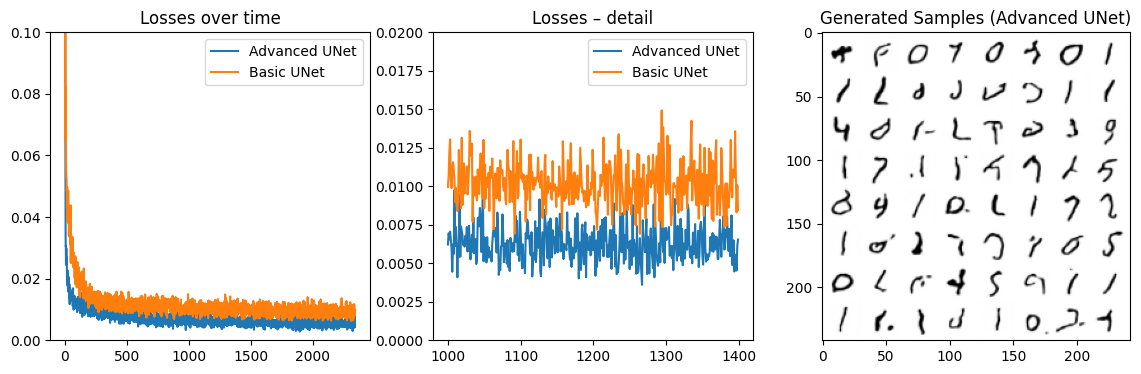

In [42]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
import numpy as np

# Losses
axs[0].plot(losses, label="Advanced UNet")
axs[0].plot(basic_losses, label="Basic UNet")
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Losses over time")
axs[0].legend()

# Losses
axs[1].plot(losses[1000:1400], label="Advanced UNet")
axs[1].plot(basic_losses[1000:1400], label="Basic UNet")
axs[1].set_ylim(0, 0.02)
axs[1].set_title("Losses – detail")
axs[1].set_xticks(np.arange(0, 401, step=100), np.arange(1000, 1401, step=100))
axs[1].legend()

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[2].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)
axs[2].set_title("Generated Samples (Advanced UNet)");

## In Depth: Diffusion Objectives

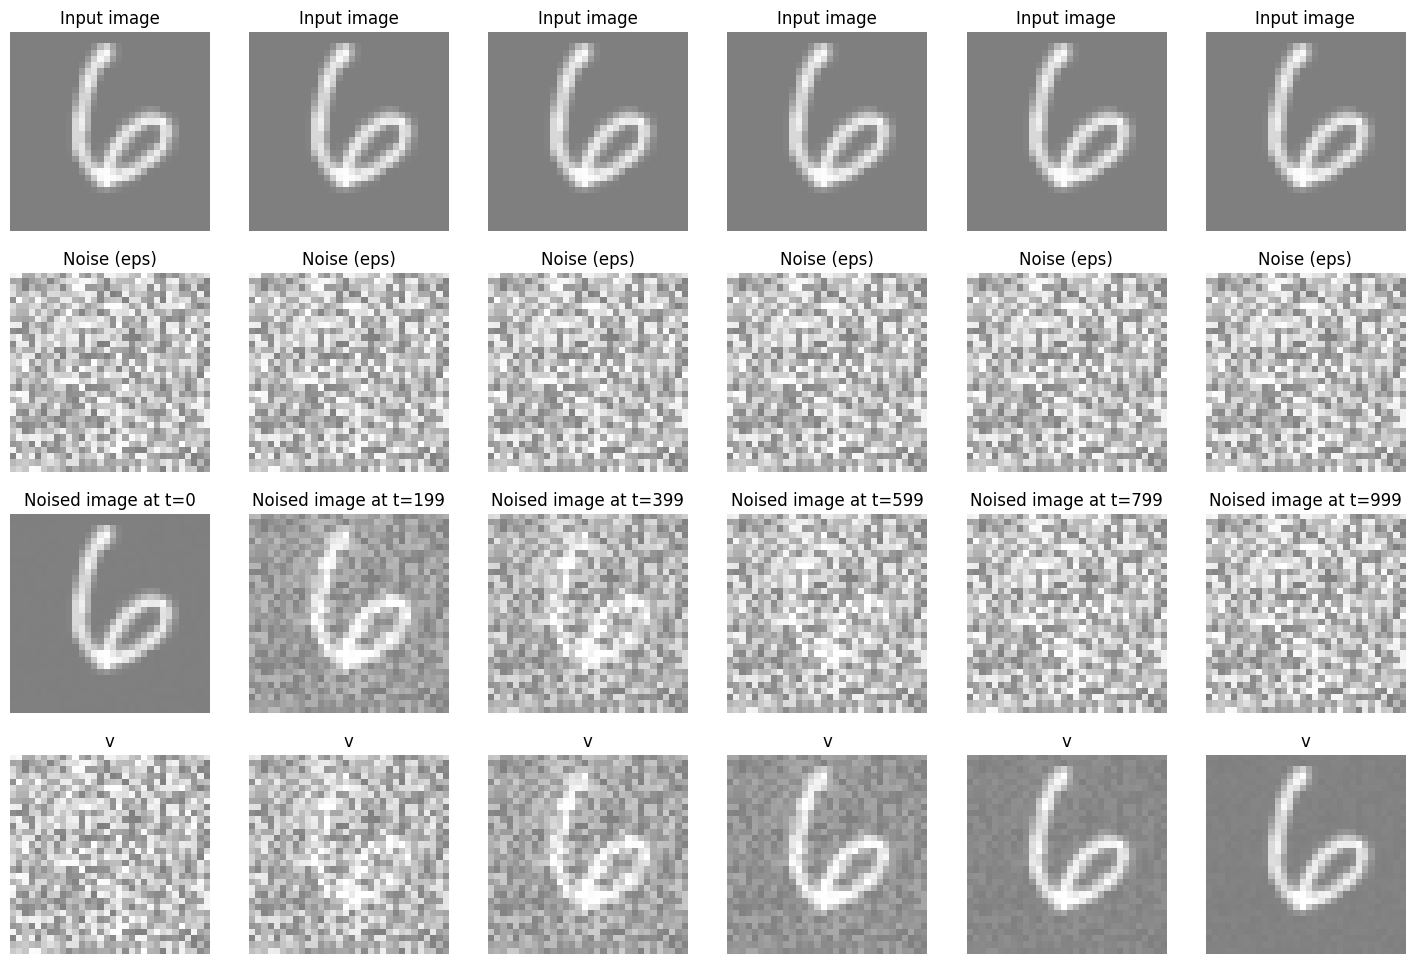

In [43]:
# Updated for large image sizes
scheduler = DDPMScheduler(beta_end=0.012)
sample = batch["images"][0]
image_size = sample.shape[-1]
noise_size = image_size  # 32
res_transform = transforms.Resize(noise_size, antialias=True)
x = res_transform(sample.expand(6, 3, image_size, image_size))
noise = torch.rand_like(res_transform(sample)).expand(
    6, 3, noise_size, noise_size
)
timesteps = torch.linspace(0, 999, 6).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
alpha_bars = scheduler.alphas_cumprod[timesteps]
v = (
    alpha_bars.view(-1, 1, 1, 1).sqrt() * noise
    + (1 - alpha_bars.view(-1, 1, 1, 1)).sqrt() * x
)
images = torch.cat(
    [
        x,
        noise,
        noised_x,
        v,
    ],
    dim=0,
)
titles = (
    ["Input image"] * 6
    + ["Noise (eps)"] * 6
    + [f"Noised image at t={t}" for t in timesteps]
    + ["v"] * 6
)

show_images(images.clip(-1, 1) * 0.5 + 0.5, ncols=6, titles=titles)

## Solutions

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the answers before taking a serious stab at it. Scroll down for the answers.

### Exercises

**1. Explain the diffusion inference algorithm.**

The diffusion inference algorithm generates samples from a diffusion model by starting with random noise and iteratively denoising it. Diffusion works as follows:

1. Start with a random sample shaped like the target data.
2. For each step in the diffusion process:
    1. Predict the noise in the current sample.
    2. Update the sample by removing the predicted noise in small steps, guided by a noise schedule

In practice, we use the timestep as a parameter to the model to predict the noise. We start with a high noise level and reduce it as we go through the steps.

```python
# Random starting point (4 random images):
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    # Get the model prediction
    with torch.no_grad():
        noise_pred = model(sample, t)["sample"]

    # Step-wise denoising update using scheduler
    sample = scheduler.step(noise_pred, t, sample).prev_sample
```

**2. What's the role of the noise scheduler?**

The noise scheduler is a helper class that define how the noise is added to the images. It receives the output of the diffusion model, a sample, and the current timestep, and returns the updated sample.

**3. When creating a training dataset of images, which characteristics are important to watch?**

1. The size of the images. The model must be able to handle images of the same size as the data.
2. The number of channels. For example, grayscale images have one channel, while RGB images have three.
3. The range of the pixel values. The model must be able to handle the range of the pixel values.
4. Wether we should apply any augmentations such as random flips or rotations.

**4. Why do we randomly flip training images?**

Randomly flipping images increases the diversity of the dataset. By introducing horizontal or vertical flips, the model encounters variations in the orientation of objects, making it more robust and generalizable.

**5. How can we evaluate the generations of diffusion models?**

We can evaluate the generations of diffusion models by using metrics such as FID or KID, but they have limitations. Human preference is the gold standard for quality but is more challenging to get.

**6. How do the values of `beta_end` impact the diffusion process?**

`beta_end` controls the end noise value for the noise scheduler. A higher value will result in more noise at the end of the process, which can result in blurrier images. A lower value will result in less noise at the end of the process, which can result in shaper images.

**7. Why do we use UNets rather than VAEs as the main model for diffusion?**

VAEs generate less precise samples. VAEs must reconstruct images from a low-dimensional latent space. On the other hand, UNet skip connections allow information to flow directly from the downsampling blocks to the upsampling blocks, helping make precise predictions and capture high-level information about the image as a whole.

**8. What benefits and challenges are faced when incorporating techniques from transformers (like attention layers or a transformer-based architecture) to diffusion?**

Transformers are more expensive in terms of compute and memory requirements. They have also struggled to scale to very high resolutions. However, they can generate high-quality samples that can lead to lower FID. Transformer-based architcture can also be more scalable backbones for larger models.

Adding attention to the UNet is another option. Self-attention layers allow the model to focus on different parts of the image at different times, which can help the model generate more complex functions. Note that attentions are also more expensive than regular convolutional layers.

### Challenges

**9. Show that**

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}
\end{equation}
$$

**is equivalent to**

$$
\begin{equation}
x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon
\end{equation}
$$

**Note that this is not a trivial example and is not required to use diffusion models. We recommend reviewing [_A Beginner's Guide to Diffusion Models: Understanding the Basics and Beyond_](https://roysubhradip.hashnode.dev/a-beginners-guide-to-diffusion-models-understanding-the-basics-and-beyond) or for guidance. An important thing to know is how to merge two Gaussians: if you have two Gaussians with different variance, $\mathcal{N}(\mu_1, \sigma_1^2)$ and $\mathcal{N}(\mu_2, \sigma_2^2)$, the resulting Gaussian is $\mathcal{N}(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)$.**

We begin by defining $\alpha_t = 1 - \beta_t$. We can then rewrite the first equation as:

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \mathbf{x}_{t-1} +  \sqrt{{1-\alpha_t}} \mathbf{\epsilon}
\end{equation}
$$

We can now expand $\mathbf{x}_{t-1}$ as:

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \left( \sqrt{\alpha_{t-1}} \mathbf{x}_{t-2} +  \sqrt{{1-\alpha_{t-1}}} \mathbf{\epsilon} \right) +  \sqrt{{1-\alpha_t}} \mathbf{\epsilon}
\end{equation}
$$

which can be rewritten as:

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \sqrt{\alpha_{t-1}} \mathbf{x}_{t-2} +  \sqrt{\alpha}_t \sqrt{{1-\alpha}_{t-1}} \mathbf{\epsilon} +  \sqrt{{1-\alpha}_t} \mathbf{\epsilon}
\end{equation}
$$



Let's now define $\bar{\alpha}_t = \Pi_{s=1}^{t} \alpha_s$ as in the reparametrization trick.

**10. This chapter uses the DDPM scheduler, sometimes requiring hundreds or thousands of steps to achieve high-quality results. Recent research has explored achieving good generations with as few steps as possible, down to even one or two! The _diffusers_ library contains multiple schedulers such as the `DDIMScheduler` from the [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) paperfootnote:[Song, Jiaming, et al. Denoising Diffusion Implicit Models. arXiv, 5 Oct. 2022. arXiv.org, https://arxiv.org/abs/2010.02502.] Create some images using the `DDIMScheduler`. This chapter's sampling section required 1000 steps with the `DDPMScheduler`. How many steps are you required to generate images with similar quality? Experiment switching the scheduler for the `google/ddpm-celebahq-256` and compare both schedulers.**

Here is how to generate with only 50 steps rather than 1000.

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.


  0%|          | 0/50 [00:00<?, ?it/s]

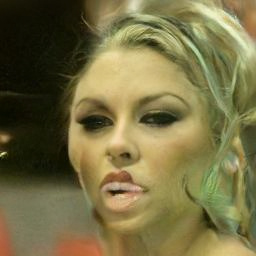

In [44]:
from diffusers import DDIMPipeline

# We can set the device to either use our GPU or use our CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pipeline
image_pipe = DDIMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

# Sample an image
image_pipe().images[0]